In [95]:
# import
import pandas as pd
from collections import OrderedDict
from operator import itemgetter    
import re
from bs4 import BeautifulSoup

import numpy as np
import json
import glob
import nltk
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from pprint import pprint

#spacy
import spacy
from nltk.corpus import stopwords

#vis
import pyLDAvis

# This one is hanged from .gensim to gensim_models
import pyLDAvis.gensim_models

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [96]:
df = pd.read_csv(r'../QBT/Empirical.csv', sep=',')
print(df.shape)


(21138, 23)


In [97]:
# Removing the "code" and "a" tag first, we want to delete what is inside the tag aswell, remvoing "a href" links and code snippets.

new_list = []
list_body = df["Body"].to_list()
temp = list_body

#print(list_body[2])
#print("-----")

for x in range(len(temp)):
    soup = BeautifulSoup(temp[x])
    codetags = soup.find_all(['code', 'a'])
    for codetag in codetags:
        codetag.extract()
        
    #print(soup)
    #print(str(soup))
    
    new_list.append(str(soup))

#print(len(new_list))
#print(new_list[2])
#print(df["Body"][1])

print("-----")
df["Body_new"] = new_list

#print(df["Body_new"][2])
print(df.shape)

-----
(21138, 24)


In [98]:
# Removing chacter and tags from the dataframe

# Removing the remaning tags
df["Body_new"] = df.Body_new.apply(lambda x: re.sub('<[^<]+?>', '', x))

# Removing ''
df["Body_new"] = df.Body_new.apply(lambda x: re.sub('\'', '', x))

# Removing ""
df["Body_new"] = df.Body_new.apply(lambda x: re.sub('\"', '', x))

df["Body_new"] = df.Body_new.apply(lambda x: re.sub('\.', ' ', x))

df["Body_new"] = df.Body_new.apply(lambda x: re.sub('\,', ' ', x))

df["Body_new"] = df.Body_new.apply(lambda x: re.sub('\!', ' ', x))

df["Body_new"] = df.Body_new.apply(lambda x: re.sub('\?', ' ', x))

df["Body_new"] = df.Body_new.apply(lambda x: re.sub('\\n', ' ', x))


print(df["Body_new"][1])

I have a node function that gets a link to YouTube video and sends a request to    Its a website that allows to download MP3 from YT  Then it parses the response HTML to get a direct download link from the document (using a library called cheerio  but if Youre not familiar with it  its just for scraping the link from HTML)  and afterwards opens the link to download the MP3  My code:  While working on my machine  this code works correctly  The console log gives a link which I can open on my browser and see that the mp3 is actually downloading  But when I run it on Lambda  the link I get has the correct format  but its simply not working  It redirects to some non-existing domain  Im not entirely sure how is this even possible  The only thing I might think about is that the website may think that the program is a bot (logically) and give a wrong link (which sounds pretty bizzare)  But I decided to also send some user-agent headers  It didnt work either  Im really confused about how can th

In [99]:
# Getting all posts with Empirical tags, this is beacuse our initial dataset contains posts with a "master"-tag of the set of tags

list_of_tages13 = ["<serverless>", "<faas>", "<serverless-framework>", "<aws-serverless>", "<openwhisk>", "<aws-lambda>", "<aws-sam>", "<aws-sam-cli>", 
"<serverless-architecture>", "<serverless-offline>", "<vercel>", "<serverless-plugins>", "<localstack>"]

What_we_want = df[df["Tags"].str.contains('|'.join(list_of_tages13))]
print(len(What_we_want))

df = What_we_want



20926


In [100]:
#  Code for creating dictonary that is counting the number of posts iwth the specific tag.
#What_we_want = What_we_want["Tags"].str.replace(r'<', '')
#What_we_want = What_we_want.str.replace(r'>', ' ')
#tags_list = What_we_want.tolist()

#list_of_tags = []
#for x in range(len(tags_list)):
#    list_of_tags.extend(tags_list[x].split())


#d = {i:list_of_tags.count(i) for i in list_of_tags}
#print(OrderedDict(sorted(d.items(), key = itemgetter(1), reverse = True)))

In [101]:
print(df.columns)
df["CommentCount"].mean()

Index(['Id', 'PostTypeId', 'AcceptedAnswerId', 'ParentId', 'CreationDate',
       'DeletionDate', 'Score', 'ViewCount', 'Body', 'OwnerUserId',
       'OwnerDisplayName', 'LastEditorUserId', 'LastEditorDisplayName',
       'LastEditDate', 'LastActivityDate', 'Title', 'Tags', 'AnswerCount',
       'CommentCount', 'FavoriteCount', 'ClosedDate', 'CommunityOwnedDate',
       'ContentLicense', 'Body_new'],
      dtype='object')


1.5611201376278314

In [102]:
synonyms = [" cost"," pricing"," Fee "," Charge","Expensive", " Pay "," Payment"," bill " ," Cheap" ," Budget"]

count = 0
for word in synonyms:
    print("----" + str(word) + "----")
    print("Body count: " + str(len(df[df['Body_new'].str.contains(word, case=False)])))
    count= count + len(df[df['Body_new'].str.contains(word, case=False)])
print(count)

---- cost----
Body count: 277
---- pricing----
Body count: 30
---- Fee ----
Body count: 4
---- Charge----
Body count: 65
----Expensive----
Body count: 71
---- Pay ----
Body count: 44
---- Payment----
Body count: 33
---- bill ----
Body count: 15
---- Cheap----
Body count: 31
---- Budget----
Body count: 6
576


In [103]:
# filtering out the final dataset

#df_temp = pd.DataFrame()
columns = ["Body_new", "Body", "Id"]
df_filtered = df[df["Body_new"].str.contains('|'.join(synonyms), case=False)]
print(len(df_filtered))

# Exporting the final data set for analysis
print(len(df_filtered))
columns = ["Id", "Body_new"]
df_export = df_filtered[columns]
df_export = df_export.sample(frac=1).reset_index(drop=True)
#df_export.to_csv(r'../final_dataset_0429.csv', sep= ",", index = False)




499
499


In [104]:
# Subsetting the data to the features needed for analysis step
print(df_filtered.columns)
columns = ["Body_new", "Body", "Id", "AnswerCount", "ViewCount", "AcceptedAnswerId", "CreationDate", "Score", "FavoriteCount", "Tags"]
df_filtered = df_filtered[columns]
df_filtered.head()

Index(['Id', 'PostTypeId', 'AcceptedAnswerId', 'ParentId', 'CreationDate',
       'DeletionDate', 'Score', 'ViewCount', 'Body', 'OwnerUserId',
       'OwnerDisplayName', 'LastEditorUserId', 'LastEditorDisplayName',
       'LastEditDate', 'LastActivityDate', 'Title', 'Tags', 'AnswerCount',
       'CommentCount', 'FavoriteCount', 'ClosedDate', 'CommunityOwnedDate',
       'ContentLicense', 'Body_new'],
      dtype='object')


,Body_new,Body,Id,AnswerCount,ViewCount,AcceptedAnswerId,CreationDate,Score,FavoriteCount,Tags
7,I am integrating a payment solution which uses...,<p>I am integrating a payment solution which u...,54114957,1,881,NaN,2019-01-09 16:55:31,1,NaN,<python-3.x><aws-lambda><boto3><amazon-cognito>
42,I am using API Gateway to build a patch method...,<p>I am using API Gateway to build a patch met...,36036500,1,627,36161069.0,2016-03-16 13:02:51,0,NaN,<amazon-web-services><aws-lambda><aws-api-gate...
63,I have an AWS Lambda function which triggers h...,<p>I have an AWS Lambda function which trigger...,54287228,1,696,NaN,2019-01-21 09:47:52,1,1.0,<node.js><amazon-web-services><aws-lambda><pul...
104,My current Situation: I currently have a Pytho...,<p><strong>My current Situation:</strong></p>\...,36298053,3,634,36300028.0,2016-03-30 01:28:16,2,NaN,<python><amazon-web-services><amazon-s3><amazo...
123,i am new to aws serverless and trying to host...,"<p>i am new to aws serverless, and trying to h...",54473954,1,246,NaN,2019-02-01 06:21:53,1,NaN,<django><amazon-web-services><amazon-s3><aws-s...


In [105]:
# Importing the coded/themed dataset for analysis
df_analysis = pd.read_excel('results.xlsx', index_col=0)
print(df_analysis.head(2))
print(df_analysis.columns)
print(df_analysis.index)

                                                         Body  \
Id                                                              
60856781.0  When triggering my Spring Boot application on ...   
55740175.0  What is the simplest and most cost effective w...   

                                          General Codes max 2  \
Id                                                              
60856781.0  Lambda Error, Unsure,  avoid cost EC2 instance...   
55740175.0  Simple solution, Cost Effective solution, Trig...   

                                Cost related Codes, Unlimited  \
Id                                                              
60856781.0  Cost Reduction by choosing spring boot instead...   
55740175.0                            Cost effective solution   

                                            Cost Theme General Themes1  \
Id                                                                       
60856781.0  Cost Reduction by avoiding using a service             EC

In [106]:
# Investigating the dataframe
df_analysis["Cost Theme"].value_counts()
df_analysis["id"] = df_analysis.index.astype(int)

print(df_analysis.index)
print(df_analysis.head())

print(df_filtered.index)
print(df_filtered.head())


Float64Index([60856781.0, 55740175.0, 58876798.0, 46168826.0, 46154682.0,
              66194572.0, 63166951.0, 55087016.0, 69246714.0, 66245987.0,
              ...
              69443194.0, 59306187.0, 54242090.0, 60714724.0, 51475033.0,
              66269219.0, 55244420.0, 60580598.0, 53467019.0, 47804191.0],
             dtype='float64', name='Id', length=499)
                                                         Body  \
Id                                                              
60856781.0  When triggering my Spring Boot application on ...   
55740175.0  What is the simplest and most cost effective w...   
58876798.0  Im doing a POC to find out how fast DynamoDB i...   
46168826.0  I am using the serverless framework with nodej...   
46154682.0  I am looking at serverless architecture to pro...   

                                          General Codes max 2  \
Id                                                              
60856781.0  Lambda Error, Unsure,  avoid cost 

In [107]:
# Mergning the dfs
result = pd.merge(df_filtered, df_analysis, left_on="Id", right_on="id", how="outer")

In [108]:

result.shape

(499, 19)

In [109]:
result.columns


Index(['Body_new', 'Body_x', 'Id', 'AnswerCount', 'ViewCount',
       'AcceptedAnswerId', 'CreationDate', 'Score', 'FavoriteCount', 'Tags',
       'Body_y', 'General Codes max 2', 'Cost related Codes, Unlimited',
       'Cost Theme', 'General Themes1', 'OLD', 'Unnamed: 7', 'Unnamed: 8',
       'id'],
      dtype='object')

In [110]:
result.index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            489, 490, 491, 492, 493, 494, 495, 496, 497, 498],
           dtype='int64', length=499)

In [111]:
result["id"].head(5)

0    54114957
1    36036500
2    54287228
3    36298053
4    54473954
Name: id, dtype: int64

In [112]:
# Creating new year column
result['CreationDate'] = pd.to_datetime(result['CreationDate'])
result['Year'] = pd.DatetimeIndex(result['CreationDate']).year
print(result["CreationDate"][1])
print(result["Year"][1])

# Create new AcceptedAnswerId column to Binary
print(result["AcceptedAnswerId"])
result["AcceptedAnswerId"] =  result["AcceptedAnswerId"].fillna(0)
result["AcceptedAnswerId"] =  result["AcceptedAnswerId"].astype("int64")
result["AcceptedAnswerId"].where(result["AcceptedAnswerId"] <=1, 1, inplace=True)
print(result["AcceptedAnswerId"].head(5))

2016-03-16 13:02:51
2016
0             NaN
1      36161069.0
2             NaN
3      36300028.0
4             NaN
          ...    
494           NaN
495           NaN
496           NaN
497    67303546.0
498           NaN
Name: AcceptedAnswerId, Length: 499, dtype: float64
0    0
1    1
2    0
3    1
4    0
Name: AcceptedAnswerId, dtype: int64


In [113]:
# Checking if categories are missing in any of the rows, this should result in 0
print(result["Cost Theme"].isna().sum())
print(result["Score"].isna().sum())

# Checking how many rows there are with categories
print(result.shape)

260
0
(499, 20)


In [114]:
# Dropping the rows without any Cost theme, if = NaN
result.dropna(subset='Cost Theme', inplace=True)
print(result.shape)
print(result["Cost Theme"].isna().sum())

result.loc[result['Cost Theme'] == "explosive billing", 'Cost Theme'] = "Expensive invoice"
# lowercasing and removing any noise froom both themes columns
result["Cost Theme"] = result["Cost Theme"].str.lower()
result["Cost Theme"] = result["Cost Theme"].str.rstrip('.!? \n\t')
result["General Themes1"] = result["General Themes1"].str.lower()
result["General Themes1"] = result["General Themes1"].str.rstrip('.!? \n\t')

# Printing the number of unique values of Cost themes
print(result["Cost Theme"].value_counts())

# Printing the number of unique values of General themes
print(result["General Themes1"].value_counts())

(239, 20)
0
cost reduction by avoiding using a service    41
cost effective implementation                 37
cost comparison                               36
cost reduction by a new design                34
implementation issues for cost reduction      25
cost estimation                               14
billing                                       13
design choice confirmation                     9
cost for no-usage                              7
cost centered development                      6
implementation causing cost                    6
explosive billing                              4
missing feature in service provider            3
unclear pricing                                2
cost calculation                               1
billing calculation                            1
Name: Cost Theme, dtype: int64
s3 bucket                      33
api gateway                    22
dynamodb                       20
ec2                            13
cold start                     10
nat

In [115]:
# converting cost themes into categories
categories = ["Solution Quality", "Design and Implementation", "Programming", "Cost Estimation", "Invoice", "Provider Feature"]
result["Cost Category"] = result["Cost Theme"]

result.loc[result['Cost Category'] == "cost comparison", 'Cost Category'] = categories[0]
result.loc[result['Cost Category'] == "design choice confirmation", 'Cost Category'] = categories[0]
result.loc[result['Cost Category'] == "implementation causing cost", 'Cost Category'] = categories[0]
result.loc[result['Cost Category'] == "cost reduction by avoiding using a service", 'Cost Category'] = categories[1]
result.loc[result['Cost Category'] == "cost reduction by a new design", 'Cost Category'] = categories[1]
result.loc[result['Cost Category'] == "cost effective implementation", 'Cost Category'] = categories[1]
result.loc[result['Cost Category'] == "cost centered development", 'Cost Category'] = categories[1]
result.loc[result['Cost Category'] == "implementation issues for cost reduction", 'Cost Category'] = categories[2]
result.loc[result['Cost Category'] == "cost for no-usage", 'Cost Category'] = categories[2]
result.loc[result['Cost Category'] == "cost estimation", 'Cost Category'] = categories[3]
result.loc[result['Cost Category'] == "billing", 'Cost Category'] = categories[3]
result.loc[result['Cost Category'] == "cost calculation", 'Cost Category'] = categories[3]
result.loc[result['Cost Category'] == "billing calculation", 'Cost Category'] = categories[3]
result.loc[result['Cost Category'] == "unclear pricing", 'Cost Category'] = categories[3]
result.loc[result['Cost Category'] == "explosive billing", 'Cost Category'] = categories[4]

result.loc[result['Cost Category'] == "missing feature in service provider", 'Cost Category'] = categories[5]


print(result["Cost Category"].value_counts())

Design and Implementation    118
Solution Quality              51
Programming                   32
Cost Estimation               31
Invoice                        4
Provider Feature               3
Name: Cost Category, dtype: int64


In [116]:
# Creating Other category for all "Cost Themes" below 10
#s = result["Cost Theme"].value_counts()
#result['Cost Theme'] = np.where(result['Cost Theme'].isin(s.index[s < 10]), 'Other', result['Cost Theme'])


# Create new dataframes for each category
list_of_dfs = []
cat = result["Cost Category"].unique()

# Splitting the dataframe into smaller ones based on categorise in a dictonary
frames = {}
for x in cat:
    frames[x] = result[result["Cost Category"] == x]

# pritng the dataframes shape
for x in cat:
    print(frames[x])

                                              Body_new  \
3    My current Situation: I currently have a Pytho...   
45   Ive already managed to create a lambda functio...   
50   Firstly Im not sure if my approach is right on...   
52   Very interested in getting hands-on with  in 2...   
65   As a quick resume i need to build a product fe...   
66   I have couple of lambda functions and all of t...   
79   I have the following situation that I try to f...   
89   I’m looking for a way to transfer cloudwatch l...   
100  Im trying to transfer files from an onsite Dro...   
119  Im thinking to launch an open-source project t...   
123  I am new to Serverless architecture using AWS ...   
125  Ive enjoyed working with  a lot lately  its co...   
138  Question Ive read  and  and  articles  But the...   
141  Ive seen a lot of people using SNS to trigger ...   
151  One Lambda is calling another in a synchronous...   
160  My requirement is to log the full request/resp...   
175  The goal 

In [117]:

plt.rcParams["figure.figsize"] = (8,5.8)

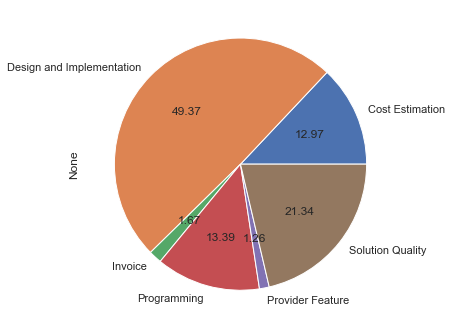

In [118]:
# RQ1

result.groupby('Cost Category').size().plot(kind='pie', autopct='%.2f')
#plt.legend(loc=7)
plt.savefig('Category.png')

In [119]:
# RQ2 quantitative

# Avg AcceptedAnswerId per Category
print("AcceptedAnswerId")
AAmean = result.groupby("Cost Category")["AcceptedAnswerId"].mean().sort_values(ascending=False)
print(AAmean)
print("----------")
# Avg AnswerCountper Category
print("AnswerCount")
ACmean = result.groupby("Cost Category")["AnswerCount"].mean().sort_values(ascending=False)
print(ACmean)
print("----------")
# Avg ViewCount per Category
print("ViewCount")
VCmean = result.groupby("Cost Category")["ViewCount"].mean().sort_values(ascending=False)
print(VCmean)
print("----------")
# Avg Score per Category
print("Score")
VCmean = result.groupby("Cost Category")["Score"].mean().sort_values(ascending=False)
print(VCmean)
print("----------")
# Avg FavoriteCount per Category
print("ViewCount")
VCmean = result.groupby("Cost Category")["FavoriteCount"].mean().sort_values(ascending=False)
print(VCmean)
print("----------")


AcceptedAnswerId
Cost Category
Provider Feature             0.666667
Cost Estimation              0.516129
Invoice                      0.500000
Solution Quality             0.470588
Programming                  0.375000
Design and Implementation    0.322034
Name: AcceptedAnswerId, dtype: float64
----------
AnswerCount
Cost Category
Provider Feature             2.333333
Programming                  1.562500
Design and Implementation    1.330508
Invoice                      1.250000
Cost Estimation              1.225806
Solution Quality             1.176471
Name: AnswerCount, dtype: float64
----------
ViewCount
Cost Category
Provider Feature             5694.666667
Programming                  2093.093750
Design and Implementation    1237.237288
Solution Quality              796.313725
Cost Estimation               793.161290
Invoice                       262.750000
Name: ViewCount, dtype: float64
----------
Score
Cost Category
Provider Feature             23.000000
Programming         

In [120]:
# RQ2 Qualitative
# Counting the number of occurences of General Theme for each Category
for x in categories:
    print("CATEGORY: " + str(x).upper())
    print(frames[x]["General Themes1"].value_counts().sort_index(ascending=True).sort_values(ascending=False))
    print("-------------------")

CATEGORY: SOLUTION QUALITY
s3 bucket                      8
api gateway                    6
dynamodb                       5
ec2                            5
lambda function invoke         4
kinesis-firehose               2
webbapp                        2
fargate                        1
function sizing and scaling    1
http                           1
aws lambda                     1
kinesis                        1
errors and exceptions          1
containers                     1
new to serverless              1
rds                            1
realm with dynamodb            1
cloud atlas                    1
sagemaker                      1
security                       1
image processing               1
Name: General Themes1, dtype: int64
-------------------
CATEGORY: DESIGN AND IMPLEMENTATION
s3 bucket                      17
dynamodb                       12
api gateway                     9
nat gateway                     9
connect vpc to rds              6
authentication    

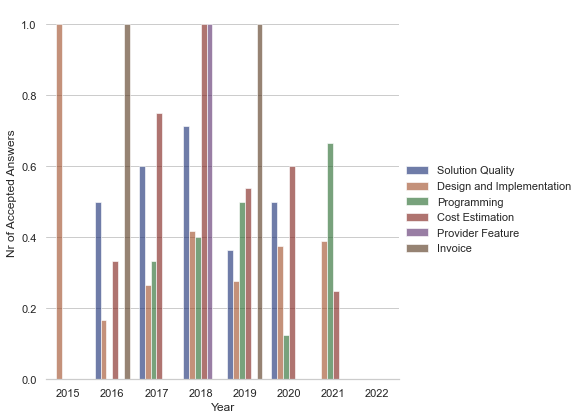

In [121]:
# RQ3

sns.set_theme(style="whitegrid")


# Draw a nested barplot by category and year for AcceptedAnswerId
g = sns.catplot(
    data=result, kind="bar",
    x="Year", y="AcceptedAnswerId", hue="Cost Category",
    ci=None, palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("Year", "Nr of Accepted Answers")
g.legend.set_title("")
plt.savefig('AcceptedAnswerId.png')

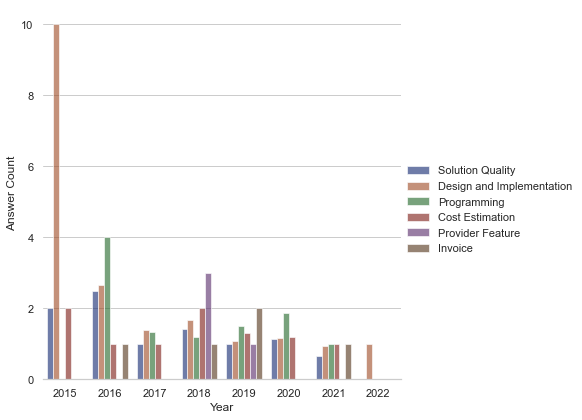

In [122]:
# Draw a nested barplot by category and year for AnswerCount
g = sns.catplot(
    data=result, kind="bar",
    x="Year", y="AnswerCount", hue="Cost Category",
    ci=None, palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("Year", "Answer Count")
g.legend.set_title("")
plt.savefig('AnswerCount.png')

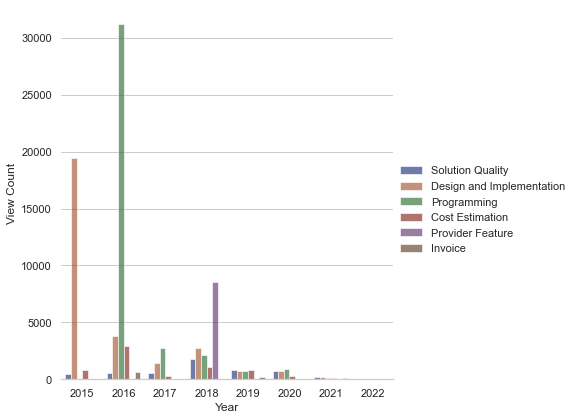

In [123]:
# Draw a nested barplot by category and year for ViewCount
g = sns.catplot(
    data=result, kind="bar",
    x="Year", y="ViewCount", hue="Cost Category",
    ci=None, palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("Year", "View Count")
g.legend.set_title("")
plt.savefig('ViewCount.png')

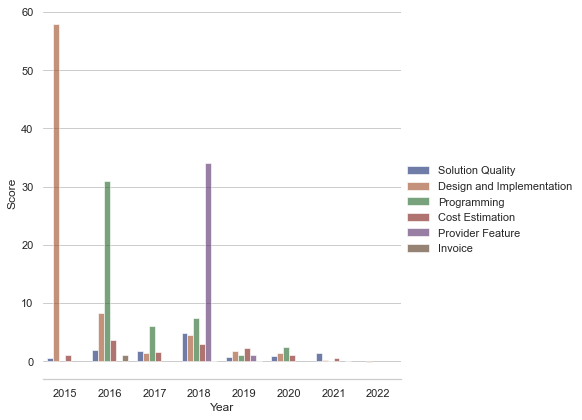

In [124]:
# Draw a nested barplot by category and year for Score
g = sns.catplot(
    data=result, kind="bar",
    x="Year", y="Score", hue="Cost Category",
    ci=None, palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("Year", "Score")
g.legend.set_title("")
plt.savefig('Score.png')

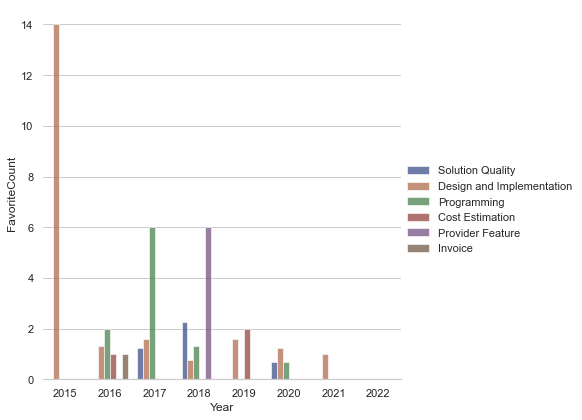

In [125]:
# Draw a nested barplot by category and year for FavoriteCount
g = sns.catplot(
    data=result, kind="bar",
    x="Year", y="FavoriteCount", hue="Cost Category",
    ci=None, palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("Year", "FavoriteCount")
g.legend.set_title("")
plt.savefig('FavoriteCount.png')